## DSCI 552 : HomeWork 3: Time Series Classification

### Name: Jayantraj CS (USC ID: 3993-1362-35)

In [693]:
# Import Statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import glob
import os
import random
import re
import csv as csv
import math
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## *Question 1.a) Download the AReM data*

In [694]:
# Defining the path of the csv files.
# We will download and directly put it in the train and test datasets.

path_of_all_csv_files = '../data/AReM'
train_file_paths,test_file_paths = [],[]

## *Question 1.(b) Split the dataset into training and test sets.*

In [695]:
# processing the paths to split the dataset.

def return_index_file_path_and_activity(v,r):
    f=int(re.findall("\d+",v)[0])
    file_path = os.path.join(r, v)
    activity = os.path.split(r)[-1]
    return f,file_path,activity

In [696]:
def get_train_test_data(train_file_paths,test_file_paths,path_of_all_csv_files,temp_list):
    for r, w, file in os.walk(path_of_all_csv_files):
        for f in file:
            if (os.path.splitext(f)[1] == '.csv'):
                index_of_csv,file_path,activity= return_index_file_path_and_activity(f,r)
                if (index_of_csv <= 2 or (activity not in temp_list and index_of_csv == 3)):
                    test_file_paths.append(file_path)
                else:
                    train_file_paths.append(file_path)
    return train_file_paths, test_file_paths

In [697]:
train_file_paths,test_file_paths=get_train_test_data(train_file_paths,test_file_paths,path_of_all_csv_files,['bending1','bending2'])

## *Question 1.(c) Feature Extraction.*

## *Question 1.(c.i) Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).*

Time domain features usually used in time series classification are:
</br>    1.Minimum
</br>    2.Maximum
</br>    3.Mean
</br>    4.Different Quantiles
</br>    5.Standard deviation
</br>    6.Number of peaks
</br>    7.Skewness
</br>    8.Kurtosis
</br>    9.Locations of minimum and maximum, etc

## *Question 1.(c.ii) Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance.*

In [698]:
# getting the column names for representing the features of all instances.

def get_column_names(num_of_features):
    format_col = ['min','max','mean','median','std','1st_quart','3rd_quart']
    columns = []
    for i in range(1,num_of_features+1):
        for j in format_col:
            columns.append(j+str(i))
    return columns

In [699]:
all_columns = get_column_names(6)

In [700]:
def get_indices(count):
    order = ['mean', 'std', 'min', '1st_quart', 'median', '3rd_quart','max']
    ordered_index = []
    for i in range(1,6*count+1):
        for j in order:
            ordered_index.append(j+str(i))
    #print(ordered_index)
    return ordered_index
    
    

In [751]:

def get_train_test_data(files, column_names, count):
    instances,target_labels = [],[]
    import csv
    sniffer = csv.Sniffer()
    for csv in files:
        p_ = os.path.dirname(csv)
        activity = os.path.split(p_)[-1]
        target_labels.append(activity)
        
        new_ = sniffer.sniff(open(csv).read()).delimiter
        
        if new_ == ",":
            current_i = pd.read_csv(csv, skiprows=5, header=None,error_bad_lines=False, warn_bad_lines=False)
        else:
            current_i = pd.read_csv(csv, skiprows=5, header=None, new_="\s+",error_bad_lines=False, warn_bad_lines=False)
        current_i.columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

        length_u = int(current_i.shape[0] / count)
        describe_s = []
        for i in range(count):
            current = current_i[i * length_u : min((i + 1) * length_u, current_i.shape[0])]
            describe_current = current.describe().drop('count').drop(columns="# Columns: time").T
            describe_s.append(describe_current.values.flatten())
        
        instances.append(np.concatenate(describe_s, axis=None))
        
    index_new = get_indices(count)
    data_frame_feature = pd.DataFrame(instances, columns=index_new)
    data_frame_feature = data_frame_feature.loc[:, column_names]
    
    data_frame_feature['target_label'] = pd.Series(target_labels)
    
    return data_frame_feature

In [702]:
train_data,test_data= get_train_test_data(train_file_paths, all_columns,1),get_train_test_data(test_file_paths, all_columns,1)

### *The fourth dataset in the bending 2 folder was not comma separted. It was cleaned manually in excel.*

## *Question 1.(c.iii.) Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.*

In [703]:
all_data = pd.concat([train_data,test_data],ignore_index=True)

In [704]:
all_features_std_deviation = all_data.describe().loc['std']
all_features_std_deviation

min1          9.569975
max1          4.394362
mean1         5.335700
median1       5.440054
std1          1.772185
1st_quart1    6.153874
3rd_quart1    5.138925
min2          0.000000
max2          5.062729
mean2         1.574198
median2       1.412293
std2          0.884137
1st_quart2    0.946386
3rd_quart2    2.125399
min3          2.956462
max3          4.875137
mean3         4.008228
median3       4.036396
std3          0.946670
1st_quart3    4.220658
3rd_quart3    4.171628
min4          0.000000
max4          2.183625
mean4         1.166178
median4       1.145985
std4          0.458283
1st_quart4    0.843405
3rd_quart4    1.552504
min5          6.124001
max5          5.741238
mean5         5.675543
median5       5.813782
std5          1.024918
1st_quart5    6.096465
3rd_quart5    5.531720
min6          0.045838
max6          2.518921
mean6         1.154889
median6       1.086474
std6          0.517651
1st_quart6    0.758687
3rd_quart6    1.523739
Name: std, dtype: float64

In [705]:
# function to get the standard deviation estimates for each of the sample.

def return_estimate(sample):
    return sample.apply(lambda column_wise : np.std(column_wise, ddof=1), axis=0)

In [706]:
# Returns a list of standard deviation estimates for all the samples.
# here we take the number of samples = 1000.

def get_standard_deviations(data,number_of_samples):
    standard_deviations = []
    for i in range(1000):
        sample = resample(data, replace=True, n_samples=number_of_samples)
        standard_deviations.append(return_estimate(sample))
    return standard_deviations

In [707]:
# Function to return the bootstrap confidence intervals.

def return_bootstrap_ci(standard_deviations,columns):
    std_df = pd.DataFrame(standard_deviations,columns=columns)
    ci = std_df.apply(lambda column_wise : (np.percentile(column_wise, 5), np.percentile(column_wise, 95)), axis=0)
    return ci.apply(np.around, args=(3,))

In [708]:
# using all the data to build bootstrap confidence intervals.

standard_deviations = get_standard_deviations(all_data.loc[:,all_data.columns != 'target_label'],all_data.shape[0])
bootstrap_confidence_intervals = return_bootstrap_ci(standard_deviations,list(train_data.columns))
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("\n The confidence interval for a feature is shown in row0,row1:")
bootstrap_confidence_intervals


 The confidence interval for a feature is shown in row0,row1:


,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,mean2,median2,std2,1st_quart2,3rd_quart2,min3,max3,mean3,median3,std3,1st_quart3,3rd_quart3,min4,max4,mean4,median4,std4,1st_quart4,3rd_quart4,min5,max5,mean5,median5,std5,1st_quart5,3rd_quart5,min6,max6,mean6,median6,std6,1st_quart6,3rd_quart6,target_label
0,8.301,3.418,4.759,4.835,1.577,5.610,4.407,0.0,4.616,1.392,1.232,0.798,0.827,1.887,2.768,4.258,3.457,3.456,0.766,3.652,3.589,0.0,1.986,1.077,1.058,0.419,0.773,1.435,4.337,4.690,4.324,4.408,0.816,4.676,4.294,0.000,2.240,1.061,0.995,0.478,0.686,1.400,NaN
1,10.887,5.310,5.910,6.023,1.955,6.664,5.885,0.0,5.425,1.712,1.551,0.942,1.037,2.301,3.110,5.484,4.531,4.578,1.131,4.757,4.707,0.0,2.344,1.222,1.205,0.487,0.891,1.628,7.523,6.623,6.766,6.935,1.211,7.225,6.552,0.078,2.768,1.219,1.152,0.546,0.811,1.607,NaN


## *Question 1.(c.iv.) Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).*

Going with max,mean and standard deviation.

## *Question 1.(d) Binary Classification Using Logistic Regression*

## *Question 1.(d.i) Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).*

In [709]:
def get_bending_train_data(train_data,temp_list):
    bending_train_data = pd.DataFrame(train_data)
    bending_train_data.loc[bending_train_data['target_label'].isin(temp_list), 'target_label'] = 1
    bending_train_data.loc[bending_train_data['target_label'] != 1, 'target_label'] = 0
    return bending_train_data

In [710]:
bending_train_data = get_bending_train_data(train_data,['bending1', 'bending2'])

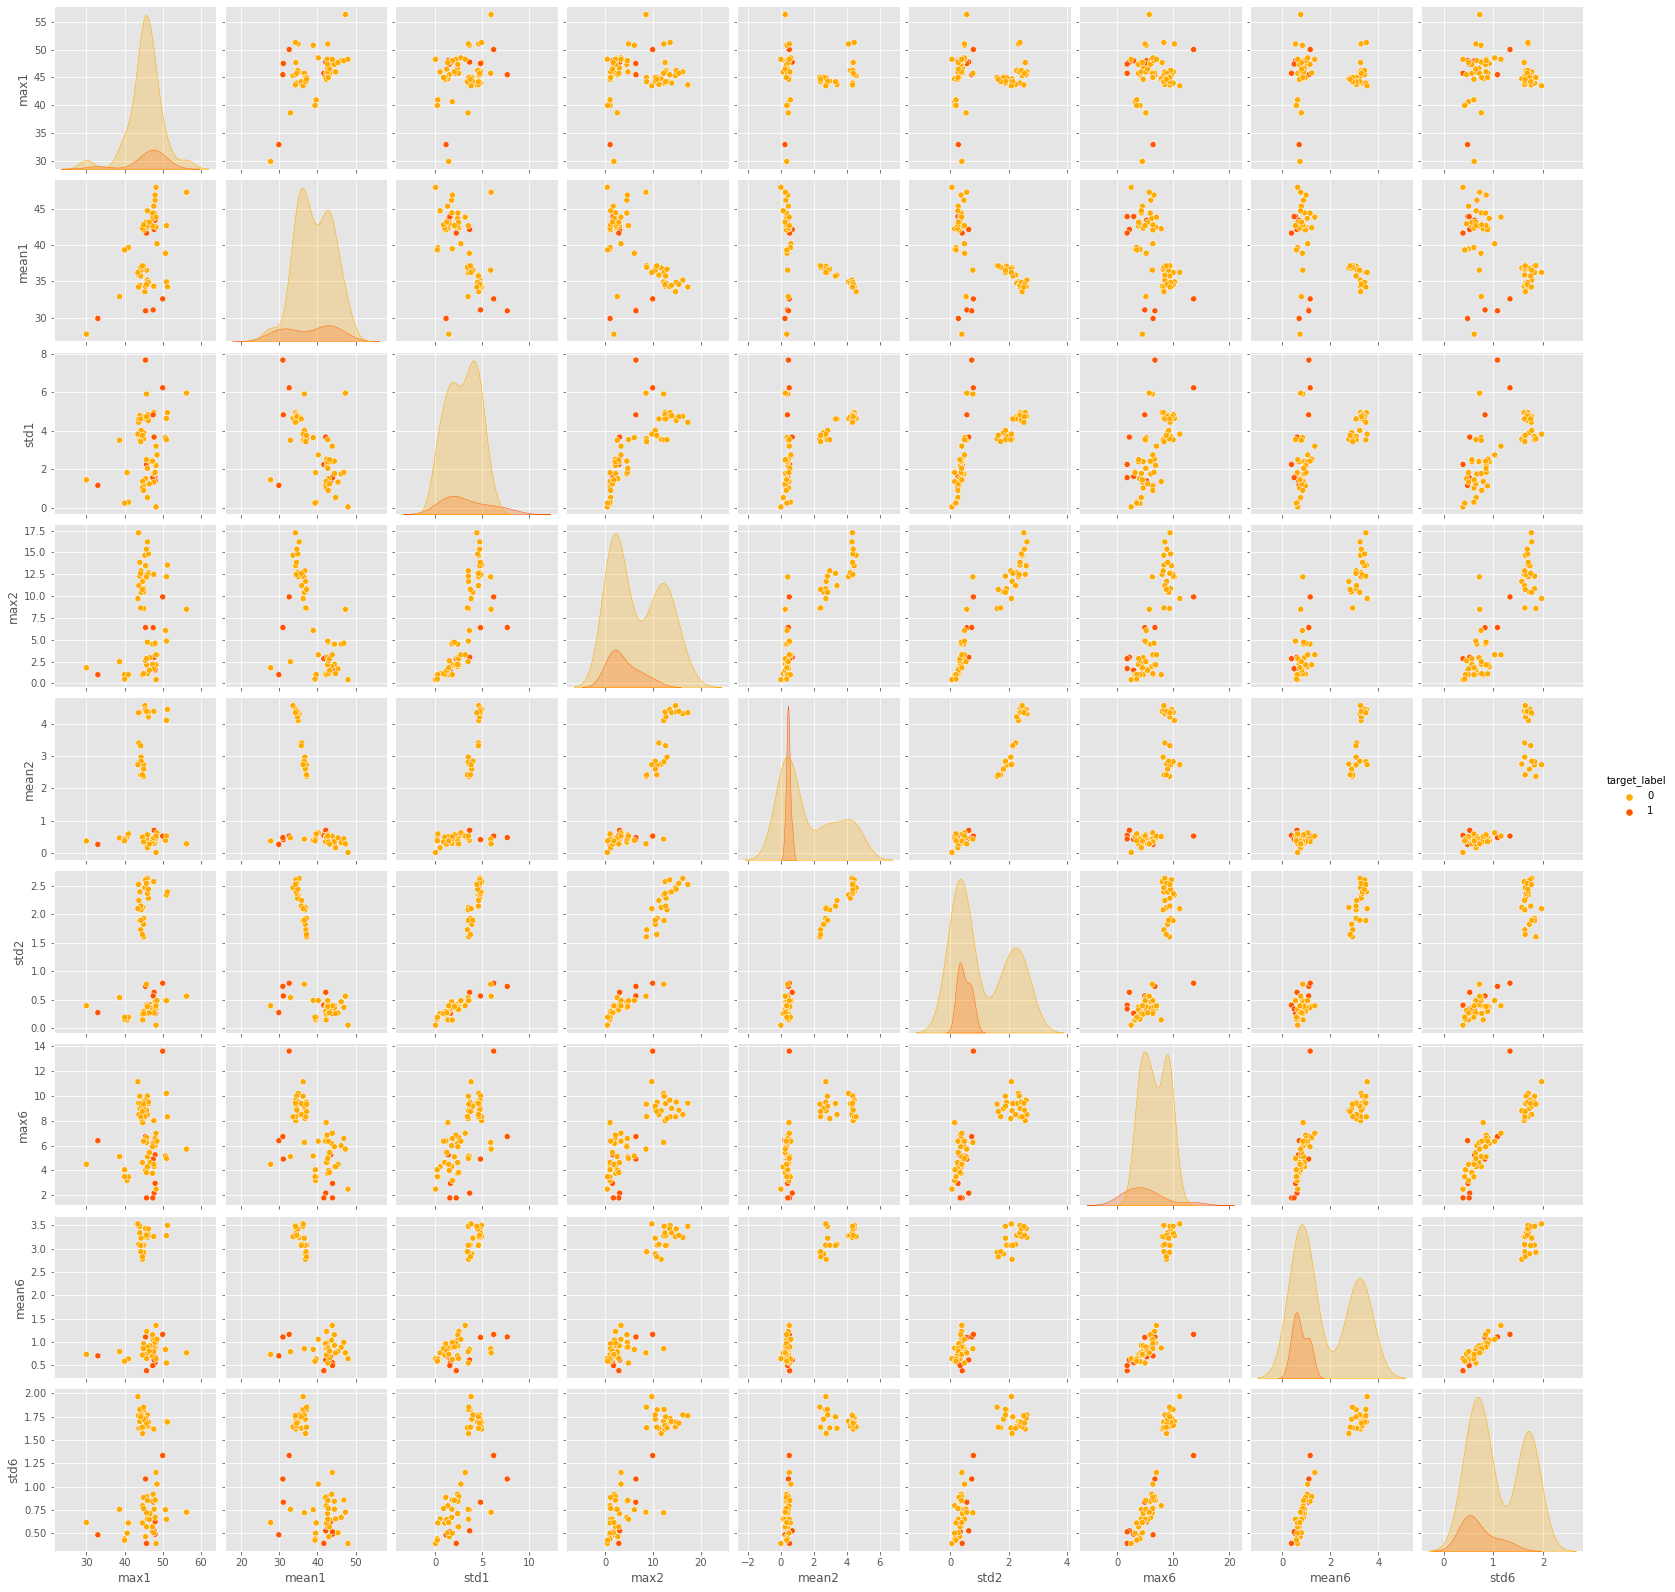

In [711]:
def scatter_plot(data, numbers, features):
    features_1 = []
    for i in numbers:
        for j in features:
            features_1.append(j+str(i))
    #print(features_1)
    #print(data)
    data_1 = data[features_1 + ['target_label']]
    sns.pairplot(data_1, hue='target_label',palette='autumn_r')
    plt.show()

# check if its 1,2,6 or 1,2,4!
scatter_plot(bending_train_data, [1, 2, 6], ['max', 'mean', 'std'])

## *Question 1.(d.ii) Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?.*

In [712]:

def split_into_two_time_series(temp_list):
    new_columns = get_column_names(12)
    double_train_data,double_test_data= get_train_test_data(train_file_paths, new_columns,2),get_train_test_data(test_file_paths,new_columns,2)
    training_bending_data = pd.DataFrame(double_train_data)
    training_bending_data.loc[training_bending_data['target_label'].isin(temp_list), 'target_label'] = 1
    training_bending_data.loc[training_bending_data['target_label'] != 1, 'target_label'] = 0
    return training_bending_data


In [713]:
training_bending_data = split_into_two_time_series(['bending1', 'bending2'])

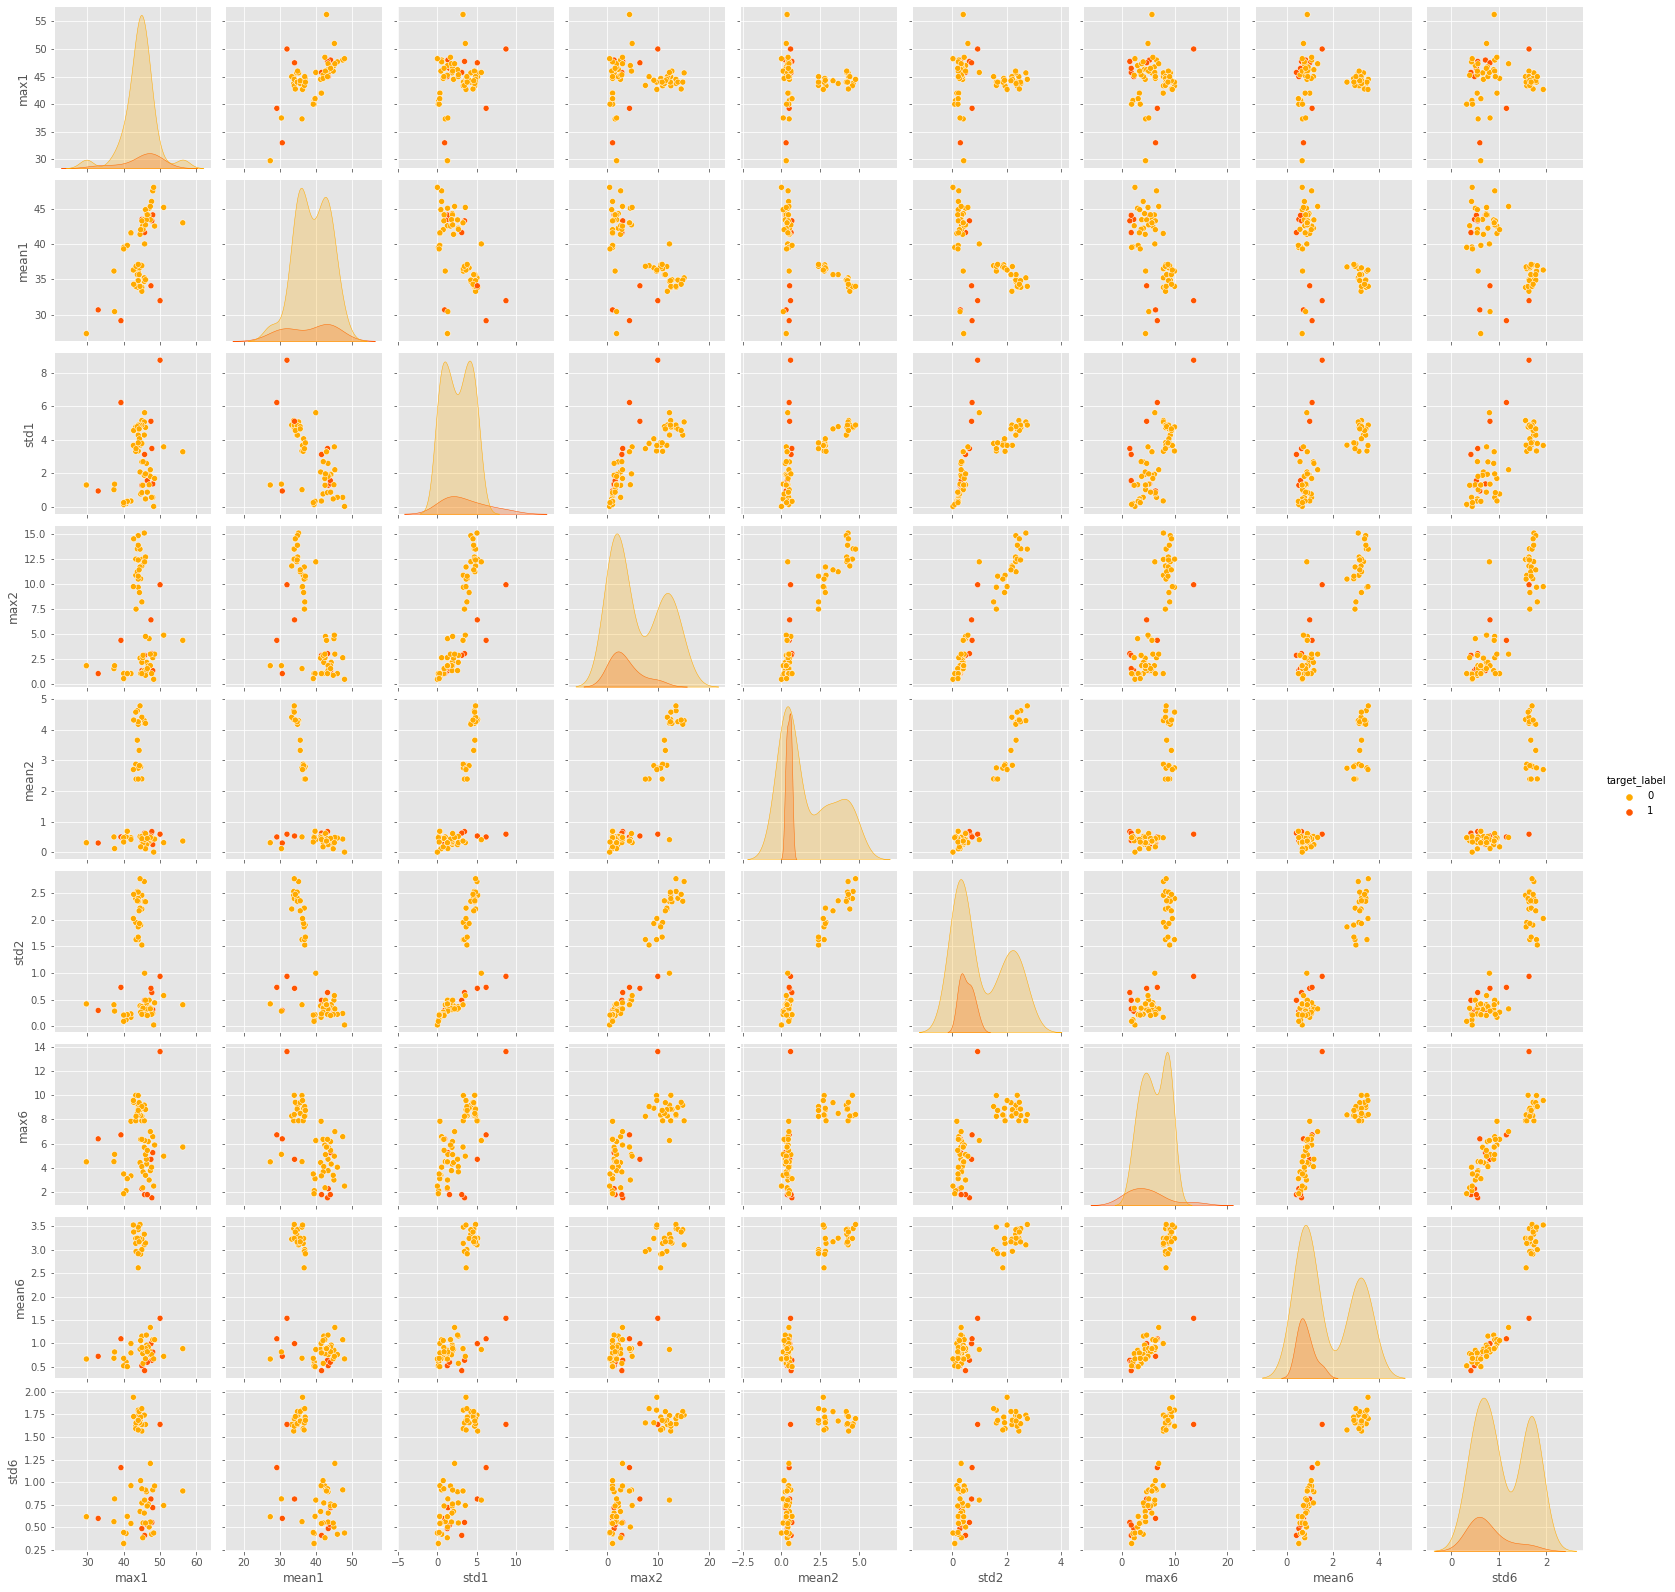

In [714]:


scatter_plot(training_bending_data, [1, 2, 12], ['max', 'mean', 'std'])


</br> 1. When we compare the above two plots we can see that the distributions look similar to each other and they vary only a little.
</br> 2. The values in some distributions in the first plot look quite stretched.

## *Question 1.(d.iii) Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance.                                                                                                                           </br> </br>Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. </br></br>Explain what the right way and the wrong way are to perform cross-validation in this problem.Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.*

In [715]:
# function to oversample the data, if there is a class imbalance.

def oversample_the_data(train_data):
    count_of_class_0,count_of_class_1= train_data.loc[train_data['target_label'] == "0"].shape[0],train_data.loc[train_data['target_label'] == "1"].shape[0]
    min_class,max_class = min(count_of_class_0, count_of_class_1), max(count_of_class_0, count_of_class_1)
    class_label_with_lowest_count = "0"
    if count_of_class_0 < count_of_class_1:
        class_label_with_lowest_count = "0"
    else:
        class_label_with_lowest_cout = "1"
    
    lowest_count_class_data,highest_count_class_data = train_data.loc[train_data['target_label'] == class_label_with_lowest_count],train_data.loc[train_data['target_label'] != class_label_with_lowest_count]
    lowest_count_class_data = resample(lowest_count_class_data, replace=True, random_state=60,n_samples=max(count_of_class_0, count_of_class_1))
    
    train_data = pd.concat([highest_count_class_data, lowest_count_class_data])
    
    return train_data,min_class,max_class

In [716]:
def logistic_regression(train_file_paths, test_file_paths, number_of_folds, l,temp_list,penalty, oversample):
   
    #new_columns = get_column_names(6*l)
    columns = ['min','max','mean','median','std','1st_quart', '3rd_quart']
    feature = [col + str(i) for i in range(1, 6 * l + 1) for col in columns]

    train_data = get_train_test_data(train_file_paths, feature,l)
    train_data.loc[train_data['target_label'].isin(temp_list), 'target_label'] = "1"
    train_data.loc[train_data['target_label'] != "1", 'target_label'] = "0"
    
    #print(type(train_data))
    if oversample:
        train_data,min_class,max_class=oversample_the_data(train_data)
    #print(type(train_data))
    #print(train_data)
    #train_data = pd.DataFrame(train_data)
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    train_x, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]
    #print(train_data)
    validator = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    feature_selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    feature_selector.fit(train_x, train_y)
    
    return model, feature_selector, validator






Note taking random_state = 69 because, when I took ranom_state = 123, 
the model.summary started giving nan values for the p-values.

In [717]:

def run_function(train_file_paths, test_file_paths, number_of_folds, L,oversample,best_p_values,scores,penalty='none'):
    
    for l in range(1, L + 1):
        classifier, selector,validator = logistic_regression(train_file_paths, test_file_paths, number_of_folds, l,['bending1', 'bending2'],penalty=penalty,oversample=oversample)
        scores.append(selector.grid_scores_)
        best_p_values.append(selector.n_features_)
        print("Given pair :", l, best_p_values[-1],end='\t')
        print("Accuracy :",max(selector.grid_scores_))
        

# 5 fold cross validation.
number_of_folds,L = 5,20

run_function(train_file_paths, test_file_paths, number_of_folds, L,False,[],[])

Given pair : 1 6	Accuracy : 1.0
Given pair : 2 5	Accuracy : 0.9428571428571428
Given pair : 3 7	Accuracy : 0.9857142857142858
Given pair : 4 9	Accuracy : 0.9714285714285715
Given pair : 5 3	Accuracy : 0.9857142857142858
Given pair : 6 36	Accuracy : 0.9857142857142858
Given pair : 7 16	Accuracy : 0.9714285714285715
Given pair : 8 31	Accuracy : 0.9714285714285715
Given pair : 9 43	Accuracy : 0.9857142857142858
Given pair : 10 47	Accuracy : 0.9714285714285715
Given pair : 11 9	Accuracy : 0.9857142857142858
Given pair : 12 85	Accuracy : 0.9857142857142858
Given pair : 13 12	Accuracy : 0.9857142857142858
Given pair : 14 15	Accuracy : 0.9714285714285715
Given pair : 15 37	Accuracy : 0.9857142857142858
Given pair : 16 12	Accuracy : 0.9857142857142858
Given pair : 17 11	Accuracy : 0.9857142857142858
Given pair : 18 9	Accuracy : 0.9857142857142858
Given pair : 19 10	Accuracy : 0.9857142857142858
Given pair : 20 11	Accuracy : 0.9857142857142858


We can see that the best pair is l=1 and p = 6, because it has the highest accuracy and lowest error rate.

## *Question 1.(d.iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them..*

In [718]:
# We are fitting the model with l=1 and 5 cross-validation.

def return_selected_features(selected_features):
    #new_columns = get_column_names(1)
    columns = ['min','max','mean','median','std','1st_quart', '3rd_quart']
    feature = [col + str(i) for i in range(1, 6 * 1 + 1) for col in columns]
    classifier, selector,validator = logistic_regression(train_file_paths, test_file_paths, 5, 1,['bending1', 'bending2'],penalty='none',oversample=False)
    #selected_features = [f for i, f in enumerate(feature) if selector.support_[i]]
    for i,f in enumerate(feature):
        if selector.support_[i]:
            selected_features.append(f)
    return selected_features,classifier,selector

selected_features,classifier,selector = return_selected_features([])
selected_features

['mean1', '3rd_quart1', 'max2', 'min5', 'max5', '1st_quart5']

We can see that the 6 selected_features are ['mean1', '3rd_quart1', 'max2', 'min5', 'max5', '1st_quart5']

In [719]:
def get_summary(train_file_paths,temp_list,selected_features):
    new_columns = get_column_names(6)
    #print(new_columns)
    train_data = get_train_test_data(train_file_paths, new_columns,1)
    train_data.loc[train_data['target_label'].isin(temp_list), 'target_label'] = 1
    train_data.loc[train_data['target_label'] != 1, 'target_label'] = 0
    train_x, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]
    #print(train_x)
    const_of_train_x = sm.add_constant(train_x.loc[:, selected_features].to_numpy(dtype=float))
    #print(const_of_train_x)
    model = sm.Logit(train_y.to_numpy(dtype=float), const_of_train_x)
    result = model.fit(method='bfgs')
    print(result.summary())
    return train_data,train_x,train_y

In [720]:
train_data,train_x,train_y = get_summary(train_file_paths,['bending1', 'bending2'],selected_features)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Oct 2021   Pseudo R-squ.:                   1.000
Time:                        22:40:03   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

In [721]:
# Function to return the confusion matrix
def return_confusion_matrix(train_y,y_prediction,y_prediction_probablity):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y.to_numpy(dtype="int"), y_prediction_probablity[:, 1], pos_label=1)
    confusion_matrix_ = confusion_matrix(train_y.to_numpy(dtype=float), y_prediction.round())
    return false_positive_rate, true_positive_rate, thresholds, confusion_matrix_
    

In [722]:
# Function to plot roc and auc
def plot_roc_and_auc(data_x,data_y,selected_features,model_classifier):
    model_classifier.fit(data_x.loc[:, selected_features], data_y.to_numpy(dtype="int"))
    y_prediction = model_classifier.predict(data_x.loc[:, selected_features])
    y_prediction_probablity = model_classifier.predict_proba(data_x.loc[:, selected_features])
    false_positive_rate, true_positive_rate, thresholds,confusion_matrix_ = return_confusion_matrix(data_y,y_prediction,y_prediction_probablity)
    fig, axes = plt.subplots(figsize=(14, 8))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    axes.plot(false_positive_rate, true_positive_rate, label="Area of ROC Curve  = {} ".format(roc_auc))
    axes.plot([0, 1], [0, 1], "-",color='green')
    axes.set_xlabel("FPR (False_Positive_Rate)")
    axes.set_ylabel("TPR (True_Positive_Rate)")
    axes.legend()
    axes.set_title("ROC Curve")
    plt.show()
    print("\nThe Confusion Matrix :")
    print(confusion_matrix_)

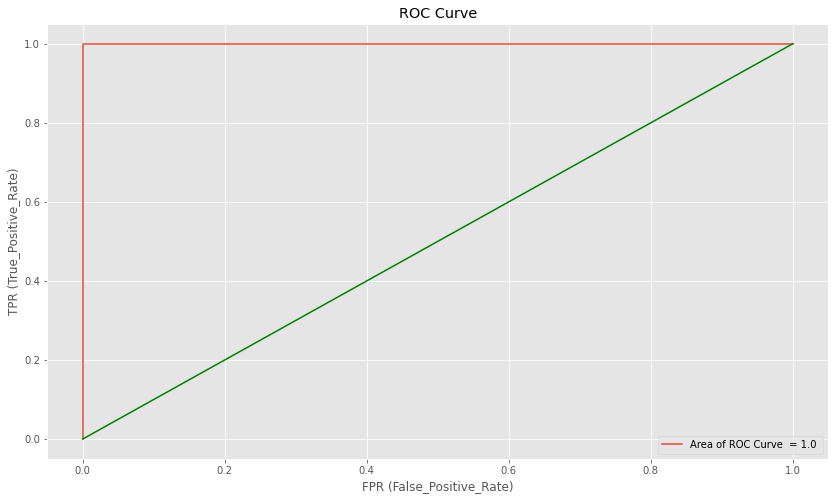


The Confusion Matrix :
[[60  0]
 [ 0  9]]


In [723]:
plot_roc_and_auc(train_x,train_y,selected_features,classifier)

## *Question 1.(d.v) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.*

In [724]:
# Function to return the new test_data after splitting up.
def return_test_data(test_file_paths,temp_list):
    new_columns = get_column_names(6)
    test_data = get_train_test_data(test_file_paths, new_columns,1)
    test_data.loc[test_data['target_label'].isin(temp_list), 'target_label'] = 1
    test_data.loc[test_data['target_label'] != 1, 'target_label'] = 0
    test_x, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]
    return test_data,test_x,test_y

In [725]:
test_data,test_x,test_y = return_test_data(test_file_paths,['bending1', 'bending2'])

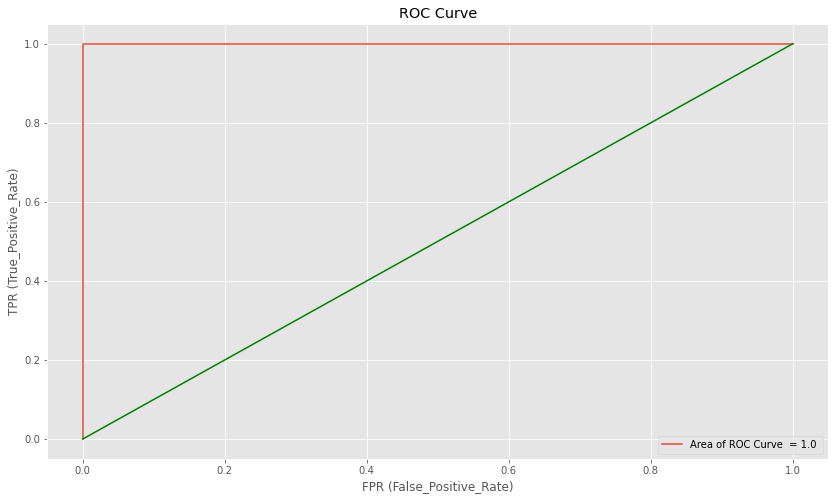


The Confusion Matrix :
[[15  0]
 [ 0  4]]


In [726]:
plot_roc_and_auc(test_x,test_y,selected_features,classifier)

</br> We can see that the results are very good, the test accuracy is perfect like the cross validation accuracy and it has no error.
</br> From the confusion matrix, we can see that, there are 15 True Negatives and 4 True Positives.

## *Question 1.(d.vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?*

</br> Yes, The classes seem to be well-separted to cause instablity in calculating the logistic regression parameters.
</br> The results summary was giving us the following output:
</br> Complete Separation: The results show that there iscomplete separation.
</br> In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.

## *Question 1.(d.vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.*

In [727]:
def get_class_counts(train_data):
    count_of_class_0,count_of_class_1 = 0,0
    for i in train_data['target_label']:
        if i ==0:
            count_of_class_0+=1
        else:
            count_of_class_1+=1
    return count_of_class_0,count_of_class_1

In [728]:
count_of_class_0,count_of_class_1 = get_class_counts(train_data)

In [729]:
print("Number of Bending classes (class=1) :",count_of_class_1)
print("Number of Non-Bending classes (class=0) :",count_of_class_0)

Number of Bending classes (class=1) : 9
Number of Non-Bending classes (class=0) : 60


The Confusion Matrix :
</br> [[60  0]
</br> [ 0  9]]

From the confusion matrix, we can see that the number of bending classes (class=1) is very less compared to the number of non-bending classes (class =0). Hence, there is a class imbalance problem.

In [731]:
# 5 fold cross validation.

# Note we are oversampling (oversampling parameter is true here) the lowest class data here from 9 to 60 samples.
number_of_folds,L = 5,20
run_function(train_file_paths, test_file_paths, number_of_folds, L,True,[],[])


Given pair : 1 10	Accuracy : 1.0
Given pair : 2 12	Accuracy : 0.9857142857142858
Given pair : 3 1	Accuracy : 1.0
Given pair : 4 1	Accuracy : 1.0
Given pair : 5 1	Accuracy : 1.0
Given pair : 6 30	Accuracy : 1.0
Given pair : 7 38	Accuracy : 1.0
Given pair : 8 42	Accuracy : 0.9857142857142858
Given pair : 9 41	Accuracy : 1.0
Given pair : 10 58	Accuracy : 1.0
Given pair : 11 52	Accuracy : 1.0
Given pair : 12 6	Accuracy : 1.0
Given pair : 13 71	Accuracy : 1.0
Given pair : 14 71	Accuracy : 1.0
Given pair : 15 59	Accuracy : 1.0
Given pair : 16 14	Accuracy : 0.9857142857142858
Given pair : 17 14	Accuracy : 1.0
Given pair : 18 6	Accuracy : 1.0
Given pair : 19 6	Accuracy : 1.0
Given pair : 20 11	Accuracy : 1.0


In [734]:
# taking l=1
def return_selected_features(selected_features):
    #new_columns = get_column_names(1)
    columns = ['min','max','mean','median','std','1st_quart', '3rd_quart']
    feature = [col + str(i) for i in range(1, 6 * 1 + 1) for col in columns]
    classifier, selector,validator = logistic_regression(train_file_paths, test_file_paths, 5, 1,['bending1', 'bending2'],penalty='none',oversample=True)
    #selected_features = [f for i, f in enumerate(feature) if selector.support_[i]]
    for i,f in enumerate(feature):
        if selector.support_[i]:
            selected_features.append(f)
    return selected_features,classifier,selector,feature

selected_features,classifier,selector,feature = return_selected_features([])
selected_features


['mean1',
 'median1',
 '3rd_quart1',
 'max2',
 'min5',
 'max5',
 'mean5',
 'median5',
 '1st_quart5',
 'max6']

We can see the 10 selected features here.

In [744]:
train_data = get_train_test_data(train_file_paths, feature,1)
train_data.loc[train_data['target_label'].isin(['bending1', 'bending2']), 'target_label'] = 1
train_data.loc[train_data['target_label'] != 1, 'target_label'] = 0


In [745]:
class_label_0 = train_data.loc[train_data['target_label'] == 0].shape[0]
class_label_1 = train_data.loc[train_data['target_label'] == 1].shape[0]
least_count = min(class_label_0, class_label_1)
high_count = max(class_label_0, class_label_1)
low_label = 1 if class_label_0 > class_label_1 else 0
low = train_data.loc[train_data['target_label'] == low_label]
high = train_data.loc[train_data['target_label'] != low_label]
low = resample(low, replace=True, n_samples=max(class_label_0, class_label_1))
train_data = pd.concat([high, low])
print("We have Oversampled the lowest class from {} to {} samples".format(least_count, high_count))

We have Oversampled the lowest class from 9 to 60 samples


In [746]:
train_x, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]


classifier.fit(train_x.loc[:, selected_features], train_y.to_numpy(dtype="int"))
predictY = classifier.predict(train_x.loc[:, selected_features])
predictY_prob = classifier.predict_proba(train_x.loc[:, selected_features])

fpr, tpr, thresholds = roc_curve(train_y.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

confusion_matrix_ = confusion_matrix(train_y.to_numpy(dtype=float), predictY.round())
print("The confusion matrix ")
print(confusion_matrix_)

The confusion matrix 
[[60  0]
 [ 0 60]]


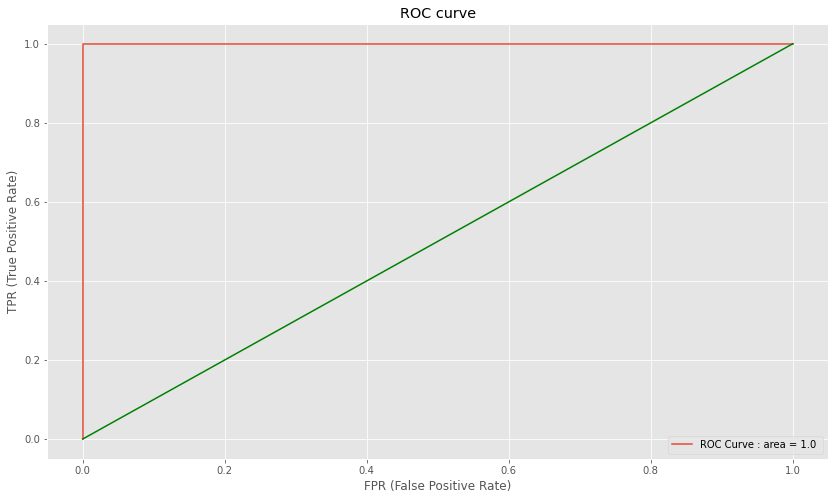

In [747]:
fig, axes = plt.subplots(figsize=(14, 8))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "-",color='green')
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_ylabel("TPR (True Positive Rate)")
axes.legend()
axes.set_title("ROC curve")
plt.show()

In [748]:
test_data = get_train_test_data(test_file_paths, feature,1)
test_data.loc[test_data['target_label'].isin(['bending1', 'bending2']), 'target_label'] = 1
test_data.loc[test_data['target_label'] != 1, 'target_label'] = 0

In [749]:
test_x, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]


classifier.fit(test_x.loc[:, selected_features], test_y.to_numpy(dtype="int"))
predictY = classifier.predict(test_x.loc[:, selected_features])
predictY_prob = classifier.predict_proba(test_x.loc[:, selected_features])

fpr, tpr, thresholds = roc_curve(test_y.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

confusion_matrix_ = confusion_matrix(test_y.to_numpy(dtype=float), predictY.round())
print("The confusion matrix ")
print(confusion_matrix_)

The confusion matrix 
[[15  0]
 [ 0  4]]


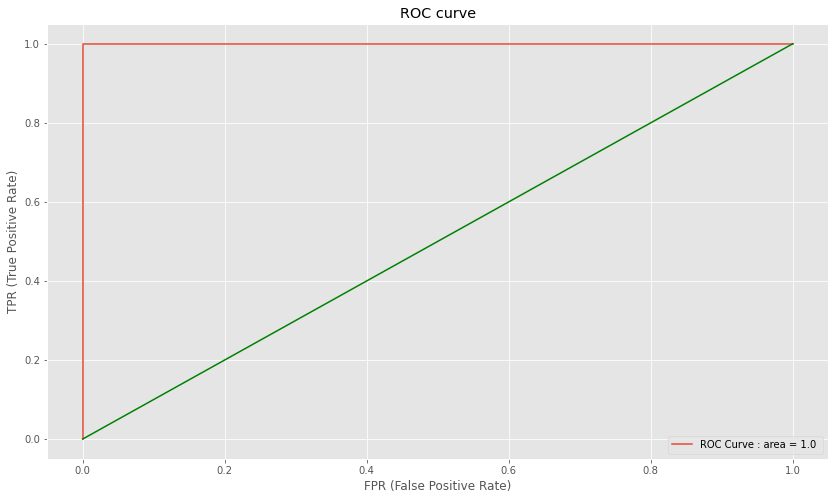

In [750]:
fig, axes = plt.subplots(figsize=(14, 8))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "-",color='green')
axes.set_xlabel("FPR (False Positive Rate)")
axes.set_ylabel("TPR (True Positive Rate)")
axes.legend()
axes.set_title("ROC curve")
plt.show()

## *Question 2. ISLR 3.7.4*

### *I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X^2 +β3X^3 +ε*

### *(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer*

</br>I would expect the RSS of the cubic regression to be lower than the RSS of the linear regression.
</br>Reason: The cubic regression has more predictors and it will give a non-linear tight fit (more flexible and complex than the linear regression) for the training data. 
</br> Hence, the cubic regression will have a lower RSS compared to linear regression.

### *(b) Answer (a) using test rather than training RSS*

</br> I would expect the cubic regression to have a higher test RSS compared to linear regression.
</br> Reason: Cubic regression will overfit the training and it would have more test error than the linear regression.

### *(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.*

</br> No matter what the true relationship is, the cubic regression will have a lower RSS compared to linear regression.
</br> Reason: The cubic regression model is more flexible and complex, hence it will follow the training data points closely. Thus, it will have a lower training error.

### *(d) Answer (c) using test rather than training RSS.*

</br> We don't have enough information to tell which model will have a lower test RSS.
</br> If the true relation is close to linear regression, then linear regression will have a lower test RSS. Else, cubic regression will have a lower test RSS.(bias-variance trade off).

## *Question 3. ISLR 4.8.3*

### *This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature. Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.*

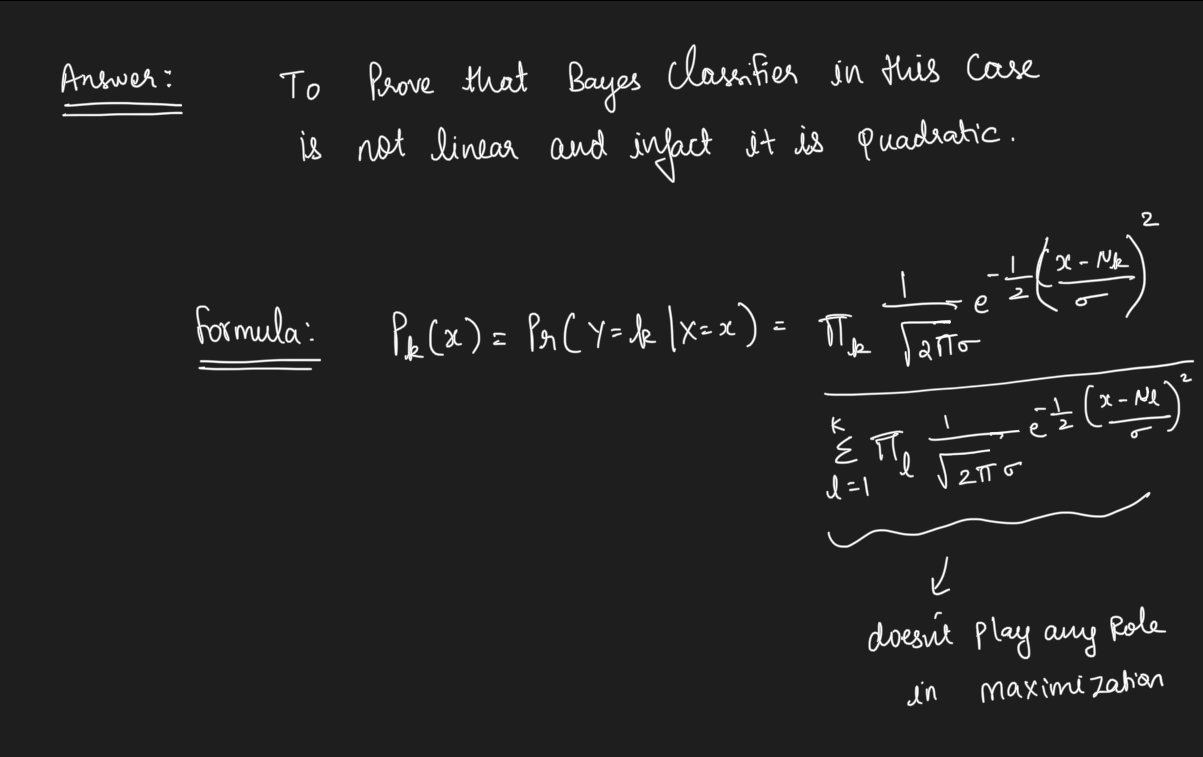

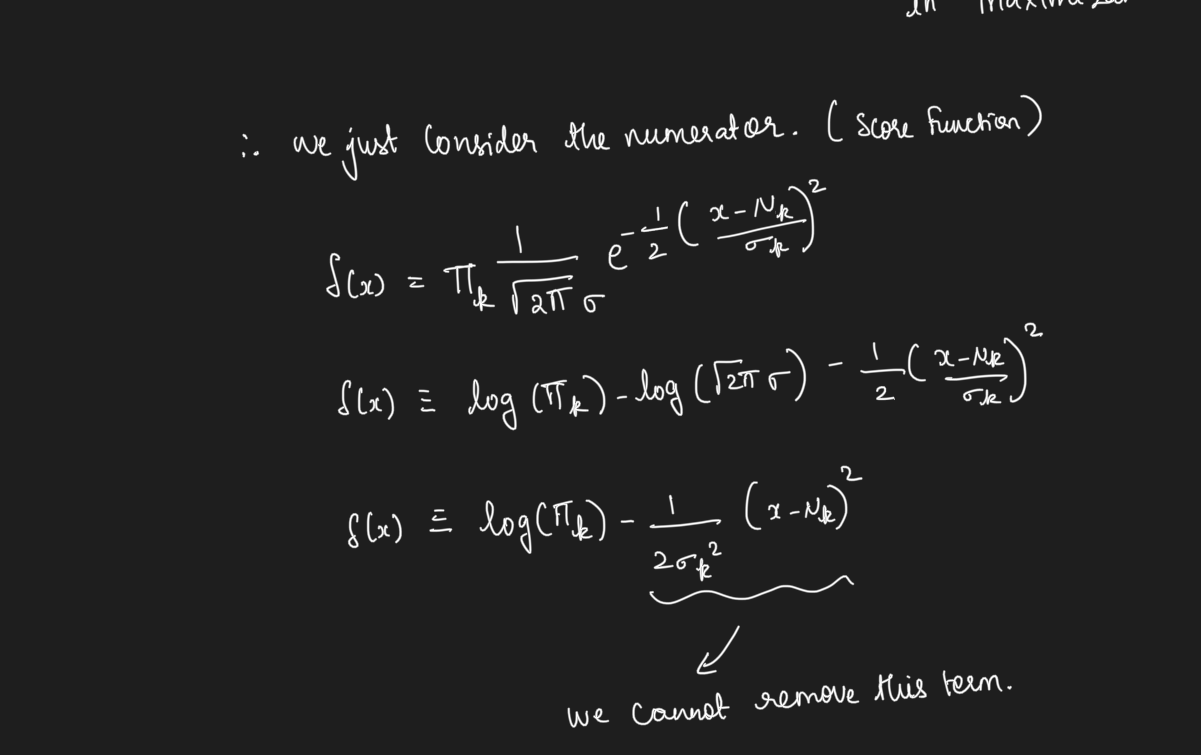

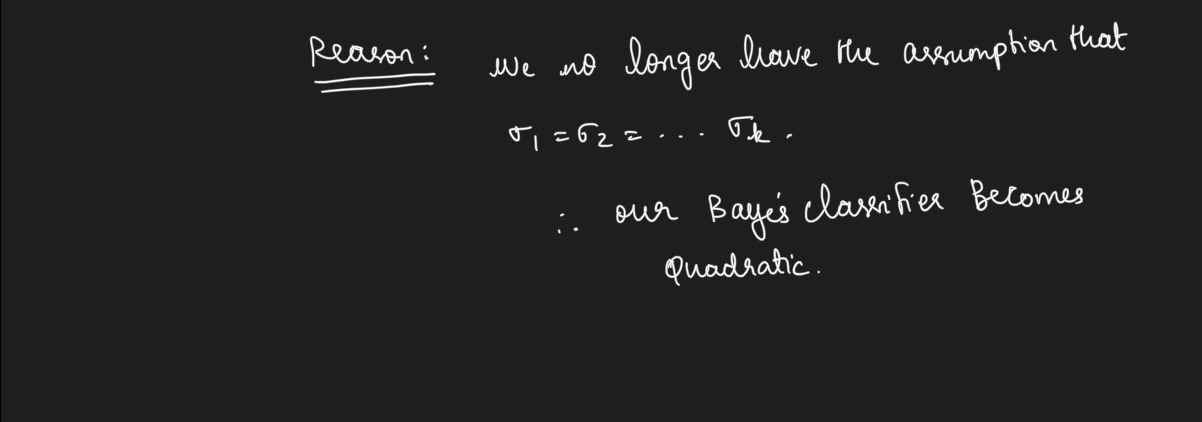

## *Question 3. ISLR 4.8.7*

### *Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was $\bar{X}$ = 10, while the mean for those that didn’t was $\bar{X}$ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.*

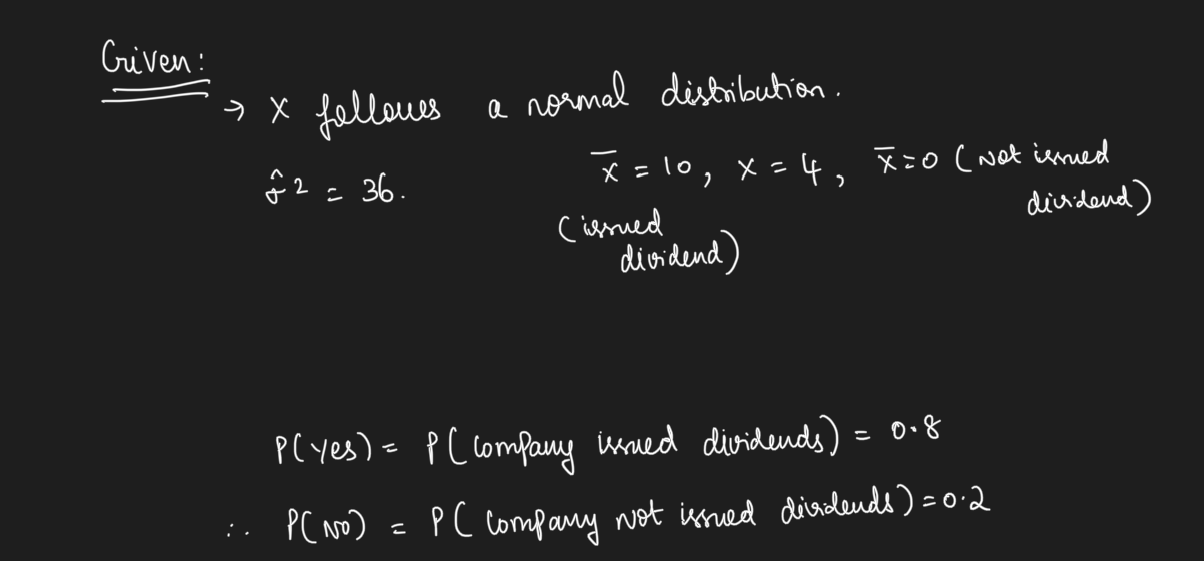

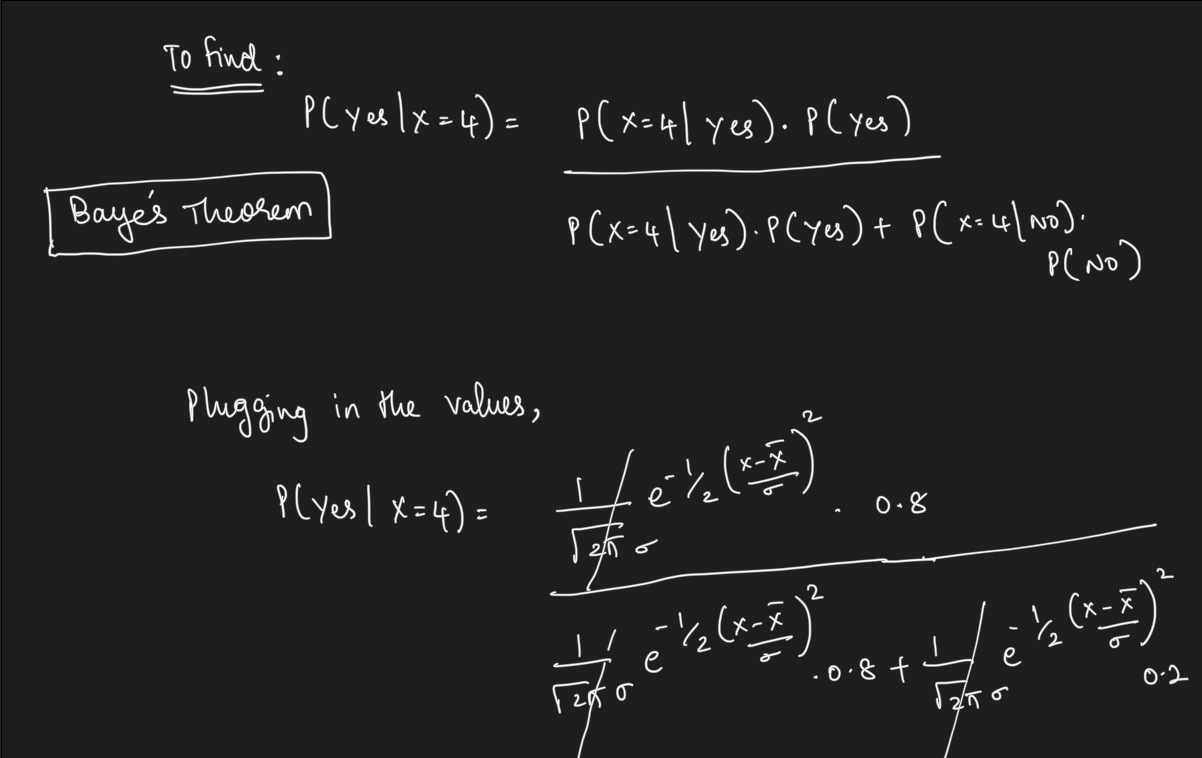

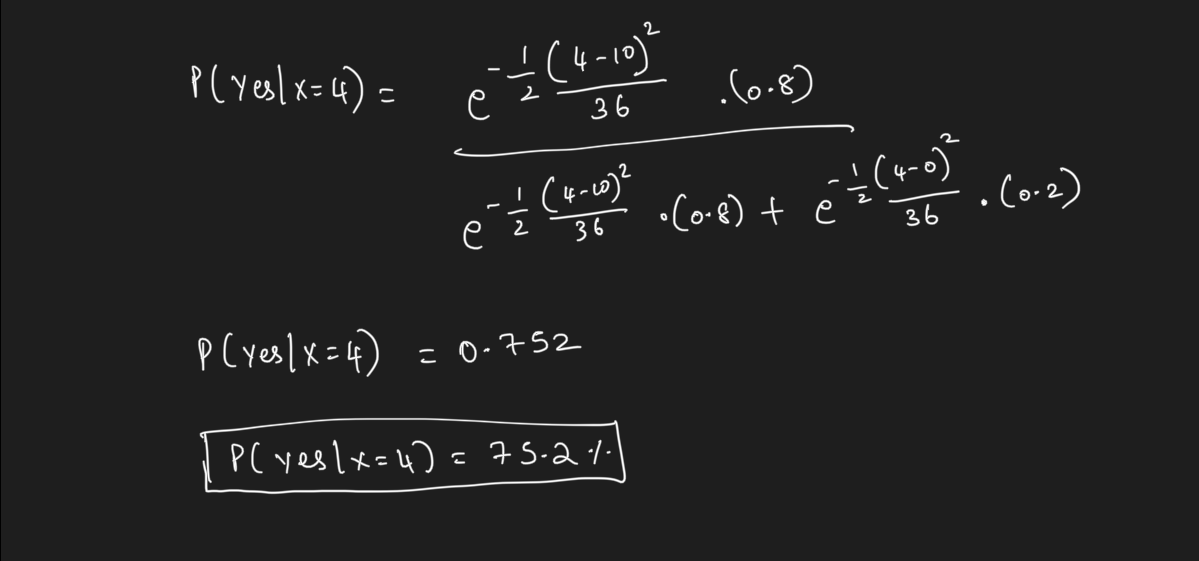